# Importação das bibliotecas necessárias


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import xgboost as xgb
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin



In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download pt_core_news_sm

     --------------------------------------- 12.8/12.8 MB 31.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     --------------------------------------- 13.0/13.0 MB 28.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [5]:
#Importando os dados
data = pd.read_csv("dados_classificados.csv")
data.sample(5)

,ID,DATA,TITULO,EMPRESA,LOCAL,LINK,DESCRICAO,RELEVANCIA
371,associate-manager-marketing-strategy-analytics...,2023-07-11,"Associate Manager, Marketing Strategy & Analyt...",Agoda,"Brasília, DF",https://br.linkedin.com/jobs/view/associate-ma...,About Agoda\n\nAgoda is an online travel booki...,0
201,gestor-de-tr%C3%A1fego-at-v4-company-3648926195,2023-07-11,Gestor de Tráfego,V4 Company,"Fortaleza, CE",https://br.linkedin.com/jobs/view/gestor-de-tr...,Gestor de tráfego\n\nVOCÊ É GESTOR(A) DE TRÁFE...,0
248,analista-de-com%C3%A9rcio-exterior-sr-at-yello...,2023-07-11,Analista de Comércio Exterior Sr.,yellow.rec,"Belo Horizonte, MG",https://br.linkedin.com/jobs/view/analista-de-...,Nível: Sênior\n\nCursos de: .\n\nEscolaridade:...,0
84,chief-product-officer-gt-school-remote-%24800-...,2023-07-11,"Chief Product Officer, gt.school (Remote) - $8...",Crossover,"Fortaleza, CE",https://br.linkedin.com/jobs/view/chief-produc...,Crossover is the world's #1 source of full-tim...,0
370,manager-search-engine-optimization-seo-%E2%80%...,2023-07-11,"Manager, Search Engine Optimization (SEO) – Ba...",Agoda,Belém e Região,https://br.linkedin.com/jobs/view/manager-sear...,About Agoda\n\nAgoda is an online travel booki...,0


# EDA

Vamos agora verificar quais são as maiores ocorrências na coluna TITULO

In [6]:
# Contar a ocorrência de cada título
title_occurrence = data['TITULO'].value_counts()

# Filtrar os títulos que aparecem mais de 3 vezes
filtered_titles = title_occurrence[title_occurrence > 3]

# Criar um DataFrame com os títulos e suas ocorrências
table_duplicates = pd.DataFrame({'Título': filtered_titles.index, 'Ocorrência': filtered_titles.values})

# Exibir a tabela na tela
print(table_duplicates)

                                               Título  Ocorrência
0   Chief Product and Technology Officer, gt.schoo...          12
1   Chief Product Officer, gt.school (Remote) - $8...          12
2   Manager, Search Engine Optimization (SEO) – Ba...          11
3                         Remote Ad Optimizer - LATAM          11
4   Part-Time Personalized Internet Ads Assessor -...          11
5   Manager, Marketing Strategy & Analytics (Bangk...          11
6   Analytical roles – Analyst/ Senior Analyst/ As...          11
7   Senior Analyst (Supply Analytics team, Bangkok...          11
8   Associate Manager, Marketing Strategy & Analyt...          11
9   Senior Manager – Marketing Strategies and Anal...          11
10  Chief Technology Officer, gt.school (Remote) -...           9
11  Part-Time Personalized Internet Ads Assessor -...           8
12                 Ubuntu Quality Engineering Manager           7
13                          Cientista de Dados Sênior           6
14        

É notável que apesar de que as linhas não são duplicadas, varias posições são duplicadas, porém anunciadas em cidades diferentes. No tratamento de variáveis vamos removê-las, e manter apenas uma ocorrência.

## Feature Engineering

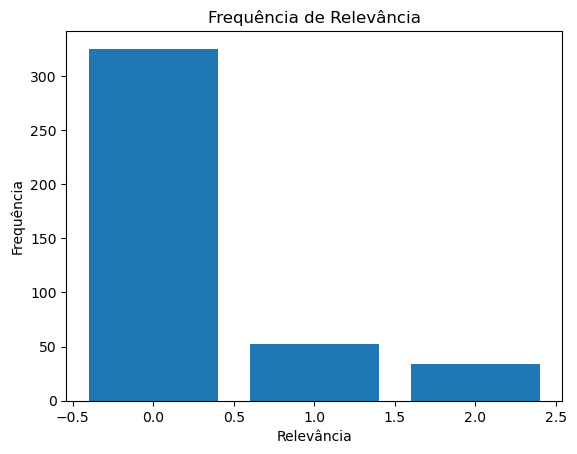

In [7]:
# Contar a frequência de cada valor na coluna "RELEVANCIA"
relevancia_counts = data['RELEVANCIA'].value_counts()

# Criar o gráfico de barras
plt.bar(relevancia_counts.index, relevancia_counts.values)

# Adicionar rótulos e título ao gráfico
plt.xlabel('Relevância')
plt.ylabel('Frequência')
plt.title('Frequência de Relevância')

# Exibir o gráfico
plt.show()

Os dados estão muito desbalanceados, como o volume de dados não é muito grande, vamos fazer algumas adaptações. Primeiro, vamos juntar todos os valores 2 com 1. Perderemos algumas informações, mas será valioso para nosso processo de treinamento do modelo

In [8]:
# Substituir os valores iguais a 2 por 1 na coluna "RELEVANCIA"
data['RELEVANCIA'] = data['RELEVANCIA'].replace(2, 1)

Assim:

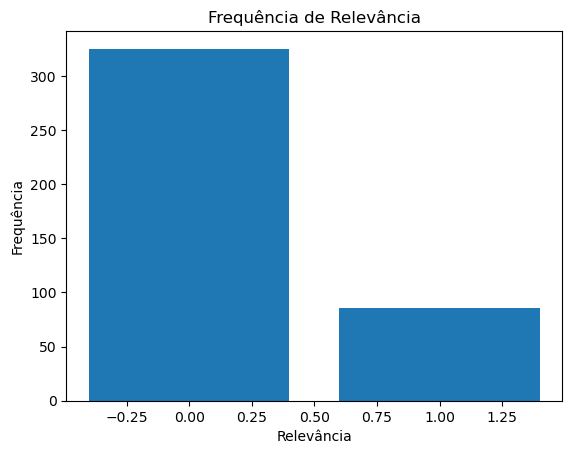

In [9]:
# Contar a frequência de cada valor na coluna "RELEVANCIA"
relevancia_counts = data['RELEVANCIA'].value_counts()

# Criar o gráfico de barras
plt.bar(relevancia_counts.index, relevancia_counts.values)

# Adicionar rótulos e título ao gráfico
plt.xlabel('Relevância')
plt.ylabel('Frequência')
plt.title('Frequência de Relevância')

# Exibir o gráfico
plt.show()

Os dados ainda estão desbalanceados, mas já é melhor do que antes. Agora vamos dividir os dados em treino e teste para continuar o feature engineering.

In [10]:
# Dividir os dados em atributos (X) e rótulos (y)
X = data.drop('RELEVANCIA', axis=1)  # Supondo que a coluna "RELEVANCIA" seja o rótulo
y = data['RELEVANCIA']

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir os tamanhos dos conjuntos de treinamento e teste
print("Tamanho do conjunto de treinamento:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treinamento: 328
Tamanho do conjunto de teste: 83


In [11]:
# Filtrar os títulos que possuem ocorrência maior ou igual a 7
titles_to_remove = table_duplicates[table_duplicates['Ocorrência'] >= 7]['Título'].tolist()

# Exibir a lista de títulos
print(titles_to_remove)


['Chief Product and Technology Officer, gt.school (Remote) - $800,000/year USD', 'Chief Product Officer, gt.school (Remote) - $800,000/year USD', 'Manager, Search Engine Optimization (SEO) – Bangkok Based, Relocation Provided', 'Remote Ad Optimizer - LATAM', 'Part-Time Personalized Internet Ads Assessor - German Speakers in Brazil', 'Manager, Marketing Strategy & Analytics (Bangkok-based, relocation provided)', 'Analytical roles – Analyst/ Senior Analyst/ Associate Manager (Bangkok Based, Relocation Provided)', 'Senior Analyst (Supply Analytics team, Bangkok-based, Relocation provided)', 'Associate Manager, Marketing Strategy & Analytics (Bangkok-based, relocation provided)', 'Senior Manager – Marketing Strategies and Analytics (Bangkok-based, relocation provided)', 'Chief Technology Officer, gt.school (Remote) - $800,000/year USD', 'Part-Time Personalized Internet Ads Assessor - Dutch Speakers in Brazil', 'Ubuntu Quality Engineering Manager']


In [12]:
# Juntar X_train e y_train em um único DataFrame
train_data = pd.concat([X_train, y_train], axis=1)

# Juntar X_test e y_test em um único DataFrame
test_data = pd.concat([X_test, y_test], axis=1)

# Remover as linhas correspondentes nos conjuntos de treinamento, mas mantendo a primeira ocorrência:
train_data = train_data[~(train_data['TITULO'].isin(titles_to_remove) & train_data.duplicated(subset='TITULO', keep='first'))]

# Remover as linhas correspondentes nos conjuntos de teste, mas mantendo a primeira ocorrência:
test_data = test_data[~(test_data['TITULO'].isin(titles_to_remove) & test_data.duplicated(subset='TITULO', keep='first'))]

# Separar novamente X_train, y_train, X_test e y_test
X_train = train_data.drop('RELEVANCIA', axis=1)
y_train = train_data['RELEVANCIA']
X_test = test_data.drop('RELEVANCIA', axis=1)
y_test = test_data['RELEVANCIA']

# Exibir os tamanhos dos conjuntos de treinamento e teste após a remoção
print("Tamanho do conjunto de treinamento após a remoção:", len(X_train))
print("Tamanho do conjunto de teste após a remoção:", len(X_test))


Tamanho do conjunto de treinamento após a remoção: 232
Tamanho do conjunto de teste após a remoção: 67


## Tratamento textual

Iremos juntar o texto do titulo com a descrição, em uma nova coluna "TEXT"

In [13]:
# Juntar as colunas "DESCRICAO", "TITULO", "LOCAL" e "EMPRESA" em uma nova coluna "TEXT" no conjunto de treinamento
X_train['TEXT'] = X_train['LOCAL'] + ' ' + X_train['EMPRESA'] + ' ' + X_train['TITULO'] + ' ' + X_train['DESCRICAO'] 

# Juntar as colunas "DESCRICAO", "TITULO", "LOCAL" e "EMPRESA" em uma nova coluna "TEXT" no conjunto de teste
X_test['TEXT'] = X_test['LOCAL'] + ' ' + X_test['EMPRESA'] + ' ' + X_test['TITULO'] + ' ' + X_test['DESCRICAO']

# Exibir as primeiras linhas dos conjuntos de treinamento e teste com a nova coluna "TEXT"
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                    ID        DATA  \
167  online-growth-vice-president-at-frubana-361057...  2023-07-11   
379  senior-manager-%E2%80%93-marketing-strategies-...  2023-07-11   
140  analista-de-business-intelligence-sr-log%C3%AD...  2023-07-11   
124  chief-product-officer-gt-school-remote-%24800-...  2023-07-11   
3    pessoa-engenheira-de-dados-junior-at-clickbus-...  2023-07-11   

                                                TITULO    EMPRESA  \
167                       Online Growth Vice President    Frubana   
379  Senior Manager – Marketing Strategies and Anal...      Agoda   
140   Analista de Business Intelligence SR - Logística  Grupo Nós   
124  Chief Product Officer, gt.school (Remote) - $8...  Crossover   
3                    PESSOA ENGENHEIRA DE DADOS JUNIOR   ClickBus   

              LOCAL                                               LINK  \
167   São Paulo, SP  https://br.linkedin.com/jobs/view/online-gro

In [14]:
# Manter apenas a coluna "TEXT" no conjunto de treinamento
X_train = X_train[['TEXT']]

# Manter apenas a coluna "TEXT" no conjunto de teste
X_test = X_test[['TEXT']]

# Exibir as primeiras linhas dos conjuntos de treinamento e teste
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                  TEXT
167  São Paulo, SP Frubana Online Growth Vice Presi...
379  Belém e Região Agoda Senior Manager – Marketin...
140  Cajamar, SP Grupo Nós Analista de Business Int...
124  Manaus, AM Crossover Chief Product Officer, gt...
3    Brasil ClickBus PESSOA ENGENHEIRA DE DADOS JUN...

Conjunto de teste:
                                                  TEXT
173  São Paulo, SP Núclea Analista BI Sr - Vaga afi...
33   São Paulo, Brasil dunnhumby Senior Applied Dat...
70   São Paulo, SP Hypera ARQUITETO DADOS Buscamos ...
362  Fortaleza, CE Agoda Associate Manager, Marketi...
82   São Paulo, SP PicPay Gerente de Crédito Sênior...


### Removendo stopwords e pontuações

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as en_stopwords
from spacy.lang.pt.stop_words import STOP_WORDS as pt_stopwords
from string import punctuation

# Carregar os modelos linguísticos
nlp_en = spacy.load('en_core_web_sm')
nlp_pt = spacy.load('pt_core_news_sm')

# Função para remover stopwords e pontuações de um texto
def remove_stopwords_punctuations(text):
    doc = nlp_en(text)
    tokens = [token.text.lower() for token in doc if token.text.lower() not in en_stopwords and token.text.lower() not in pt_stopwords and token.text not in punctuation]
    return ' '.join(tokens)

# Remover stopwords e pontuações do conjunto de treinamento
X_train['TEXT'] = X_train['TEXT'].apply(remove_stopwords_punctuations)

# Remover stopwords e pontuações do conjunto de teste
X_test['TEXT'] = X_test['TEXT'].apply(remove_stopwords_punctuations)

# Exibir as primeiras linhas dos conjuntos de treinamento e teste após a remoção
print("Conjunto de treinamento:")
print(X_train.head())
print()
print("Conjunto de teste:")
print(X_test.head())


Conjunto de treinamento:
                                                  TEXT
167  paulo sp frubana online growth vice president ...
379  belém região agoda senior manager – marketing ...
140  cajamar sp analista business intelligence sr l...
124  manaus crossover chief product officer gt.scho...
3    brasil clickbus pessoa engenheira dados junior...

Conjunto de teste:
                                                  TEXT
173  paulo sp núclea analista bi sr vaga afirmativa...
33   paulo brasil dunnhumby senior applied data sci...
70   paulo sp hypera arquiteto dados buscamos talen...
362  fortaleza ce agoda associate manager marketing...
82   paulo sp picpay gerente crédito sênior modelag...


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

# Criar um vetorizador TF-IDF
vectorizer = TfidfVectorizer()

# Transformar os dados de texto em vetores TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train['TEXT'])
X_test_tfidf = vectorizer.transform(X_test['TEXT'])


# Save the fitted vectorizer for later use
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
    

# Inicializar o classificador Random Forest
clf = RandomForestClassifier(random_state=42)

# Treinar o classificador usando o conjunto de treinamento vetorizado
clf.fit(X_train_tfidf, y_train)

# Fazer previsões no conjunto de teste vetorizado
y_pred = clf.predict(X_test_tfidf)

# Avaliar o desempenho do modelo
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.68      0.95      0.79        42
           1       0.75      0.24      0.36        25

    accuracy                           0.69        67
   macro avg       0.71      0.60      0.58        67
weighted avg       0.70      0.69      0.63        67



In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Convert the training and test data into a DMatrix for use with XGBoost
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dtest = xgb.DMatrix(X_test_tfidf, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'seed': 42
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Save the trained model for later use
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Make predictions on the test set
y_pred = model.predict(dtest)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model's performance
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.81      0.93      0.87        42
           1       0.84      0.64      0.73        25

    accuracy                           0.82        67
   macro avg       0.83      0.78      0.80        67
weighted avg       0.82      0.82      0.81        67



##### O modelo com XGBoost possui boas métricas, e será utilizado como modelo final.

In [18]:
import pickle

# Salvar o modelo em um arquivo pickle
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Criando pipeline focado em produção


In [3]:
nltk.download('stopwords')

# Define a function to remove stopwords and punctuation
def remove_stopwords_punctuation(text):
    stop_words = set(stopwords.words('portuguese') + stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words and token not in string.punctuation]
    return ' '.join(filtered_tokens)

class XGBoostClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        with open(self.model_path, 'rb') as file:
            self.model = pickle.load(file)
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        dmatrix_data = xgb.DMatrix(X)
        probabilities = self.model.predict(dmatrix_data)
        predictions = [1 if prob > 0.5 else 0 for prob in probabilities]
        return predictions

# Load the TfidfVectorizer from the file
with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Create the pipeline
pipeline = Pipeline([
    ('combine_columns', FunctionTransformer(lambda x: x['DESCRICAO'] + ' ' + x['TITULO'] + ' ' + x['LOCAL'] + ' ' + x['EMPRESA'], validate=False)),
    ('add_text_column', FunctionTransformer(lambda x: pd.DataFrame({'TEXT': x}), validate=False)),
    ('remove_punctuation', FunctionTransformer(lambda x: x['TEXT'].apply(remove_stopwords_punctuation), validate=False)),
    ('drop_columns', FunctionTransformer(lambda x: x.drop(columns=['DESCRICAO', 'TITULO', 'LOCAL', 'EMPRESA']), validate=False)),
    ('tfidf_vectorizer', vectorizer),
    ('prediction', XGBoostClassifier('xgboost_model.pkl'))
])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Criando dados sintéticos para testar nosso pipeline:

Pedi o ChatGPT para gerar novos dados sintéticos, de 10 empregos, onde 5 eu classificaria como "Relevante", e mais 5 que eu consideraria irrelevante:

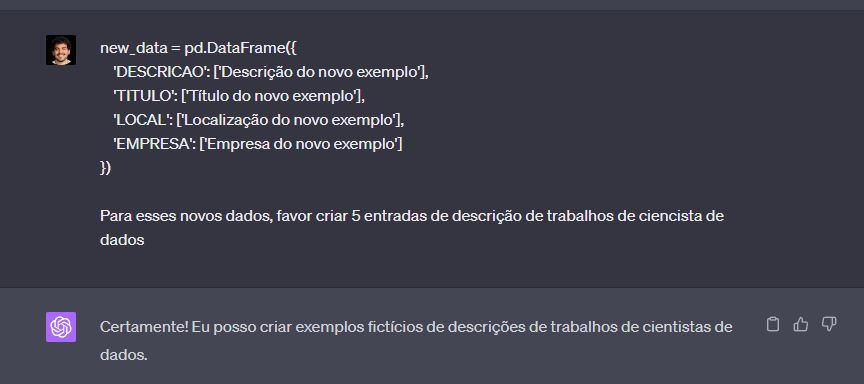

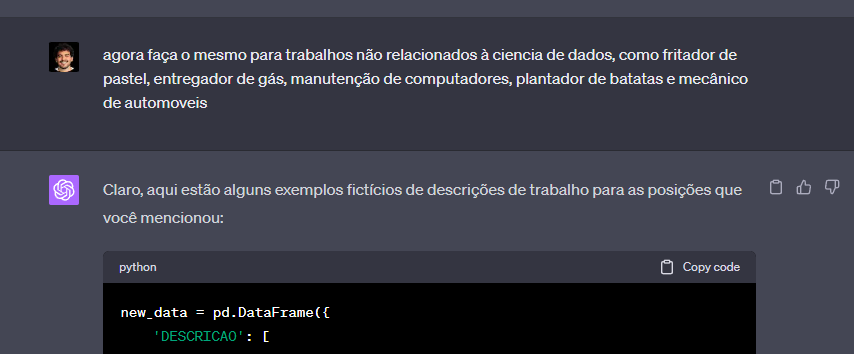

In [20]:
new_data = pd.DataFrame({
    'DESCRICAO': [
        "O candidato selecionado irá colaborar com nossa equipe de análise para coletar, analisar e interpretar resultados complexos de dados. As responsabilidades incluem limpeza de dados, criação de algoritmos, teste de modelos e apresentação de resultados de uma maneira clara e visual.",
        "Procuramos um cientista de dados com especialização em machine learning para ajudar a desenvolver soluções inovadoras para problemas complexos. O candidato irá projetar e implementar modelos de machine learning, bem como gerenciar o processamento e a análise de grandes conjuntos de dados.",
        "Nossa empresa está em busca de um cientista de dados para liderar nossos esforços de análise de dados. O candidato deverá possuir uma forte compreensão dos modelos estatísticos e experiência com linguagens de programação como Python ou R. A capacidade de se comunicar efetivamente com as equipes de TI e gestão é crucial.",
        "Esta posição exige um profissional com experiência em ciência de dados e habilidades em SQL e Python. O candidato será responsável pela criação de algoritmos de machine learning, mineração de dados e apresentação de insights de dados para ajudar na tomada de decisões estratégicas.",
        "Estamos à procura de um cientista de dados talentoso para extrair, analisar e interpretar grandes quantidades de dados de várias fontes. O candidato deve ter uma forte compreensão das técnicas de análise de dados e uma aptidão para trabalhar com grandes conjuntos de dados.",
        "Estamos procurando um fritador de pastel com experiência em preparação de alimentos. O candidato deve ser capaz de preparar a massa, recheio, e manter o local de trabalho limpo e higiênico.",
        "Precisamos de um entregador de gás responsável e pontual para garantir a entrega segura e eficiente de nossos produtos aos clientes. Deve ser capaz de carregar peso, ter habilidades de atendimento ao cliente e possuir CNH válida.",
        "Buscamos um profissional de manutenção de computadores para resolver problemas de hardware e software. Experiência com sistemas operacionais Windows e MacOS é necessária, assim como capacidade de solucionar problemas de rede.",
        "Estamos contratando um plantador de batatas para nossa fazenda. O candidato ideal deve ter experiência em agricultura, ser capaz de operar maquinário agrícola e estar disposto a trabalhar ao ar livre em várias condições climáticas.",
        "Procuramos um mecânico de automóveis com experiência em diagnóstico e reparo de uma ampla gama de problemas de veículos. Deve ser capaz de trabalhar com ferramentas de diagnóstico modernas e ter excelente atendimento ao cliente."
    ],
    'TITULO': [
        'Cientista de Dados Júnior',
        'Cientista de Dados com Especialização em Machine Learning',
        'Cientista de Dados Sênior',
        'Cientista de Dados Especializado em SQL e Python',
        'Cientista de Dados para Extração e Análise de Dados',
        'Fritador de Pastel',
        'Entregador de Gás',
        'Técnico de Manutenção de Computadores',
        'Plantador de Batatas',
        'Mecânico de Automóveis'
    ],
    'LOCAL': [
        'São Paulo, SP',
        'Rio de Janeiro, RJ',
        'Belo Horizonte, MG',
        'Porto Alegre, RS',
        'Salvador, BA',
        'Curitiba, PR',
        'Recife, PE',
        'Fortaleza, CE',
        'Cuiabá, MT',
        'Manaus, AM'
    ],
    'EMPRESA': [
        'Meta',
        'Hotmart',
        'Artefact',
        'Google',
        'Vale',
        'Pastelaria 1',
        'Distribuidora de Gás 2',
        'Assistência Técnica 3',
        'Fazenda 4',
        'Oficina Mecânica 5'
    ]
})


In [21]:
new_data.head(10)

,DESCRICAO,TITULO,LOCAL,EMPRESA
0,O candidato selecionado irá colaborar com noss...,Cientista de Dados Júnior,"São Paulo, SP",Meta
1,Procuramos um cientista de dados com especiali...,Cientista de Dados com Especialização em Machi...,"Rio de Janeiro, RJ",Hotmart
2,Nossa empresa está em busca de um cientista de...,Cientista de Dados Sênior,"Belo Horizonte, MG",Artefact
3,Esta posição exige um profissional com experiê...,Cientista de Dados Especializado em SQL e Python,"Porto Alegre, RS",Google
4,Estamos à procura de um cientista de dados tal...,Cientista de Dados para Extração e Análise de ...,"Salvador, BA",Vale
5,Estamos procurando um fritador de pastel com e...,Fritador de Pastel,"Curitiba, PR",Pastelaria 1
6,Precisamos de um entregador de gás responsável...,Entregador de Gás,"Recife, PE",Distribuidora de Gás 2
7,Buscamos um profissional de manutenção de comp...,Técnico de Manutenção de Computadores,"Fortaleza, CE",Assistência Técnica 3
8,Estamos contratando um plantador de batatas pa...,Plantador de Batatas,"Cuiabá, MT",Fazenda 4
9,Procuramos um mecânico de automóveis com exper...,Mecânico de Automóveis,"Manaus, AM",Oficina Mecânica 5


Os cinco primeiros devem ser classificados como 1, e os outro 5 como 0:

In [22]:
# Exemplo de uso do pipeline para prever novos dados

predictions = pipeline.predict(new_data)
print(predictions)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


##### Péssima perfomance. FIca a lição que dados sintéticos não costumam performar bem rs. Vamos tentar com novos dados coletados em newly_fetched_data.csv

In [4]:
data_new = pd.read_csv("newly_fetched_data.csv")

predictions = pipeline.predict(data_new)
print(predictions)

[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
# Criar um novo DataFrame com as colunas de data_new e predictions
df_combined = pd.concat([data_new, pd.DataFrame(predictions)], axis=1)

In [7]:
df_combined.sample(10)

,ID,DATA,TITULO,EMPRESA,LOCAL,LINK,DESCRICAO,0
29,vaga-de-est%C3%A1gio-ci%C3%AAncia-de-dados-dat...,2023-07-13,Vaga de Estágio Ciência de Dados (Data Science...,121 Labs,"Belo Horizonte, MG",https://br.linkedin.com/jobs/view/vaga-de-est%...,A 121 Labs é um laboratório de inovação com fo...,0
27,data-scientist-supply-chain-management-remote-...,2023-07-13,Data Scientist (Supply Chain Management) - Rem...,Mondelēz International,Brasil,https://br.linkedin.com/jobs/view/data-scienti...,Job Description\n\nAre You Ready to Make It Ha...,1
63,senior-data-engineer-poatek-brazil-applicants-...,2023-07-13,Senior Data Engineer (Poatek- Brazil Applicants),WillowTree,"Porto Alegre, RS",https://br.linkedin.com/jobs/view/senior-data-...,"Senior Data Engineer\n\nSão Paulo-SP, Brazil o...",0
62,senior-data-engineer-poatek-brazil-applicants-...,2023-07-13,Senior Data Engineer (Poatek- Brazil Applicants),WillowTree,"Porto Alegre, RS",https://br.linkedin.com/jobs/view/senior-data-...,"Senior Data Engineer\n\nSão Paulo-SP, Brazil o...",0
61,platform-react-native-engineer-poatek-brazil-a...,2023-07-13,Platform React Native Engineer (Poatek- Brazil...,WillowTree,"São Paulo, Brasil",https://br.linkedin.com/jobs/view/platform-rea...,Mid-Level React Native Engineer\n\nSão Paulo-S...,0
36,data-analytics-analyst-cross-border-team-at-sh...,2023-07-13,Data & Analytics Analyst (Cross Border Team),Shopee,"São Paulo, SP",https://br.linkedin.com/jobs/view/data-analyti...,"Job Description\n\nDevelop reports, dashboards...",0
14,senior-data-scientist-poatek-brazil-applicants...,2023-07-13,Senior Data Scientist (Poatek- Brazil Applicants),WillowTree,"São Paulo, Brasil",https://br.linkedin.com/jobs/view/senior-data-...,"Senior Data Scientist\n\nSão Paulo-SP, Brazil ...",1
17,real-world-late-phase-clinical-operations-lead...,2023-07-13,Real World Late Phase - Clinical Operations Lead,IQVIA,"São Paulo, SP",https://br.linkedin.com/jobs/view/real-world-l...,Job Overview:\n\nIndependently direct the exec...,0
53,principal-data-scientist-poatek-brazil-applica...,2023-07-13,Principal Data Scientist (Poatek- Brazil Appli...,WillowTree,"Porto Alegre, RS",https://br.linkedin.com/jobs/view/principal-da...,"Principal Data Scientist\n\nSão Paulo-SP, Braz...",1
11,digital-solution-consultant-kalypso-at-kalypso...,2023-07-13,Digital Solution Consultant - Kalypso,Kalypso: A Rockwell Automation Business,"Jundiaí, SP",https://br.linkedin.com/jobs/view/digital-solu...,Rockwell Automation is a global technology lea...,0


## Conclusões

Conforme esperado - dada as métricas apresentadadas pelo modelo em treino - o modelo performou muito bem com novos dados, assinalando vagas com a relevância correta.

Um ponto interessante é a demonstração do data drift. Ao utilizarmos dados sintéticos, com uma sintaxe e formatação completamente diferente, o modelo performou muito mal.

Já com dados reais, coletados na mesma formatação com que o modelo foi treinado, o modelo performa muito bem.